In [70]:
import pygad
import numpy as np
import sys
import random

from IPython.display import clear_output

import matplotlib.pyplot as plt
from scipy.special import comb

import dataset
import bezier_spline

random.seed(0.5)

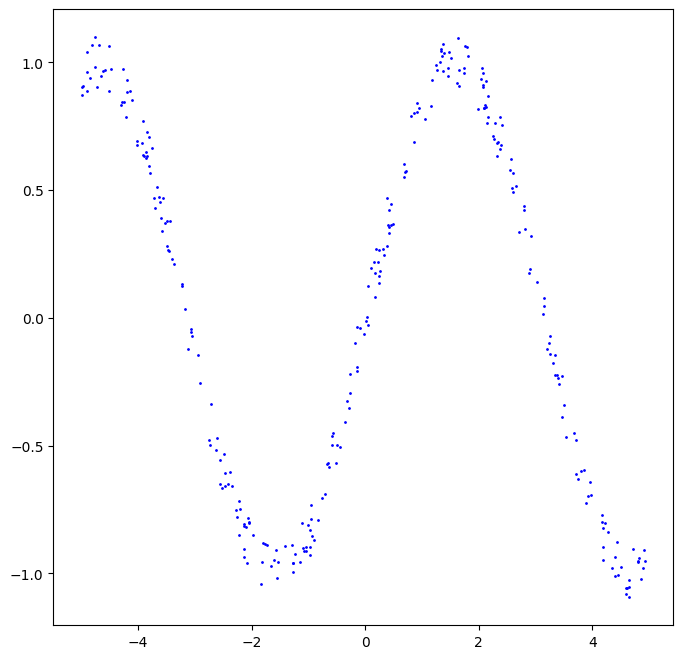

In [71]:
S = dataset.TrigonDataset() #MagmanDataset()
S.sample(size=300, noise=0.1)
S.plot()

In [72]:
spline = bezier_spline.BezierCurveConnector(0., S.xu)
for _ in range(1):
    spline.connect(bezier_spline.BezierCurve())

#spline = bezier_spline.BezierCurve()
#spline.fixnode(1, 'x', -2.)
#spline.fixnode(4, 'x', -1.)
#spline.bindnode(3, 2, 'x')
#spline.bindnode(3, 2, 'y')

def fitfunc(ga_instance, solution, solution_idx):
    spline.set_chromo(solution)
    return spline.fitness(S)

def crossover_func(parents, offspring_size, ga_instance):  # single point crossover
    offspring = []
    idx = 0
    while len(offspring) != offspring_size[0]:
        
        added = False
        for _ in range(10):
            parent1 = parents[idx % parents.shape[0], :].copy()
            parent2 = parents[(idx + 1) % parents.shape[0], :].copy()

            random_split_point = np.random.choice(range(offspring_size[1]))

            parent1[random_split_point:] = parent2[random_split_point:]

            spline.set_chromo(np.array(parent1))
            if spline.isvalid(S):
                offspring.append(parent1)
                added = True
                break
        
        if not added:
            raise RuntimeError('Crossover error. Invalid limit exceeded.')
        idx += 1

    return np.array(offspring)

def mutation_func(offspring, ga_instance):
    for chromosome_idx in range(offspring.shape[0]):
        random_gene_idx = np.random.choice(range(offspring.shape[1]))

        added = False
        for _ in range(100):
            delta = np.random.uniform(-0.5, 0.5)  # TODO: choose it
            mutated = offspring[chromosome_idx].copy()
            mutated[random_gene_idx] += delta
            spline.set_chromo(mutated)
            
            if spline.isvalid(S):
                offspring[chromosome_idx, random_gene_idx] += delta
                added = True
                break
        
        if not added:
            raise RuntimeError('Mutation error. Invalid limit exceeded.')
        
    return offspring

def create_initial_population(size:int) -> np.array:
    pop = []
    chromo_len = spline.get_chromo_length()
    for _ in range(size):
        added = False
        for _ in range(100000):
            chromo = []
            for _ in range(chromo_len):
                chromo.append(random.uniform(-4.5, 4.5))  # TODO: adjust limits
            
            spline.set_chromo(np.array(chromo))
            if spline.isvalid(S):
                pop.append(chromo)
                added = True
                break
        
        if not added:
            raise RuntimeError('Random chrome error. Invalid limit exceeded.')
    
    return np.array(pop)


def callback_generation(ga_instance):
    clear_output(wait=True)
    print("Generation = {generation}".format(generation=ga_instance.generations_completed))
    #print("Fitness    = {fitness}".format(fitness=ga_instance.best_solution()[1]))

function_inputs = spline.get_chromo_length()

In [73]:
fitness_function = fitfunc

num_generations = 100
num_parents_mating = 4

sol_per_pop = 100 #10
num_genes = function_inputs

initial_population = create_initial_population(sol_per_pop)

parent_selection_type = "sss"
keep_parents = 1

crossover_type = crossover_func #"single_point"

mutation_type = mutation_func #"random"
mutation_percent_genes = 1

In [74]:
ga_instance = pygad.GA(num_generations=num_generations,
                       num_parents_mating=num_parents_mating,
                       fitness_func=fitness_function,
                       sol_per_pop=sol_per_pop,
                       num_genes=num_genes,
                       initial_population=initial_population,
                       parent_selection_type=parent_selection_type,
                       keep_parents=keep_parents,
                       crossover_type=crossover_type,
                       mutation_type=mutation_type,
                       mutation_percent_genes=mutation_percent_genes,
                       on_generation=callback_generation)

c:\Users\Agostino\AppData\Local\Programs\Python\Python311\Lib\site-packages\pygad\pygad.py:748: UserWarning: The percentage of genes to mutate (mutation_percent_genes=1) resutled in selecting (0) genes. The number of genes to mutate is set to 1 (mutation_num_genes=1).
If you do not want to mutate any gene, please set mutation_type=None.
  warnings.warn(f"The percentage of genes to mutate (mutation_percent_genes={mutation_percent_genes}) resutled in selecting ({mutation_num_genes}) genes. The number of genes to mutate is set to 1 (mutation_num_genes=1).\nIf you do not want to mutate any gene, please set mutation_type=None.")


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Generation = 100
Parameters of the best solution : [-0.07430923  2.38888183  3.04722884  3.44708192 -1.81882037 -0.86349865]
Fitness value of the best solution = 3037000499.97605
Predicted output based on the best solution : 36.759386039264655


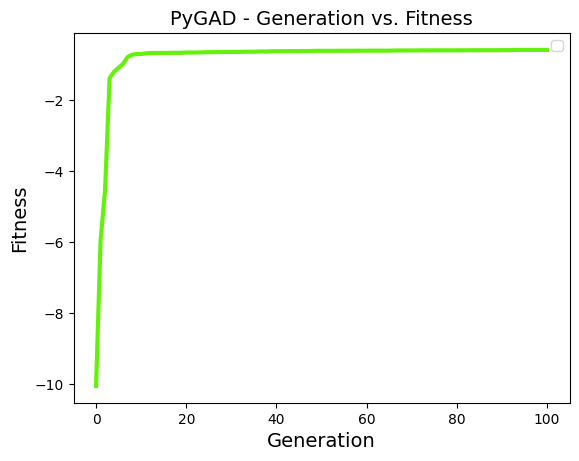

In [75]:
ga_instance.run()

from math import sqrt

solution, solution_fitness, solution_idx = ga_instance.best_solution()
print("Parameters of the best solution : {solution}".format(solution=solution))
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=sqrt(sys.maxsize-solution_fitness)))

prediction = np.sum(np.array(function_inputs)*solution)
print("Predicted output based on the best solution : {prediction}".format(prediction=prediction))

ga_instance.plot_fitness();

-0.5934918800712591

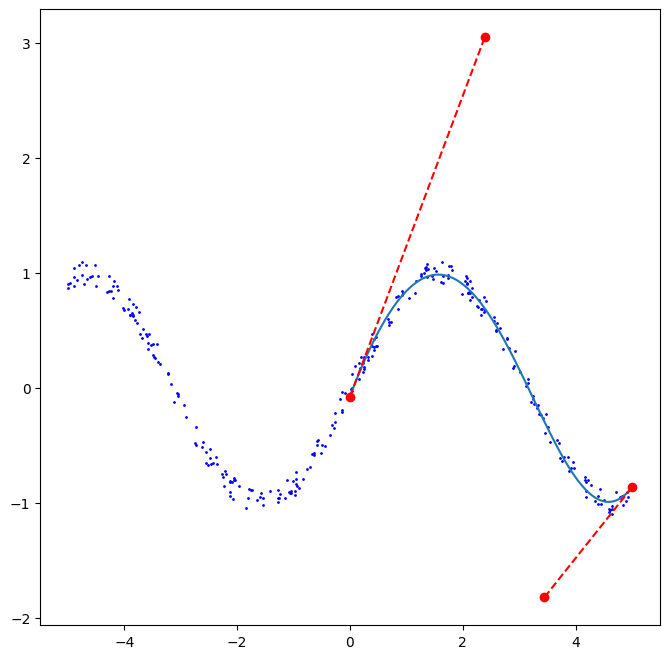

In [76]:
S.plot()
spline.set_chromo(solution)
spline.plot()
spline.fitness(S)